In [1]:
%pip install transformers datasets accelerate

   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.0 MB 3.2 MB/s eta 0:00:04
   ----- ---------------------------------- 1.6/12.0 MB 4.4 MB/s eta 0:00:03
   --------- ------------------------------ 2.9/12.0 MB 5.1 MB/s eta 0:00:02
   --------------- ------------------------ 4.7/12.0 MB 5.9 MB/s eta 0:00:02
   ----------------------- ---------------- 7.1/12.0 MB 7.0 MB/s eta 0:00:01
   -------------------------------- ------- 9.7/12.0 MB 7.9 MB/s eta 0:00:01
   ---------------------------------------  11.8/12.0 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 12.0/12.0 MB 8.2 MB/s  0:00:01
   ---------------------------------------- 0.0/566.1 kB ? eta -:--:--
   ---------------------------------------- 566.1/566.1 kB 9.9 MB/s  0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------------------------------- -------- 2.1/2.7 MB 10.7 MB/s eta 0:00:01
   ------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

Using device: cpu


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\ajang\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ajang\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2 - Train loss: 0.2020
Epoch 1/2 - Val loss: 0.0800
Epoch 2/2 - Train loss: 0.0616
Epoch 2/2 - Val loss: 0.0686


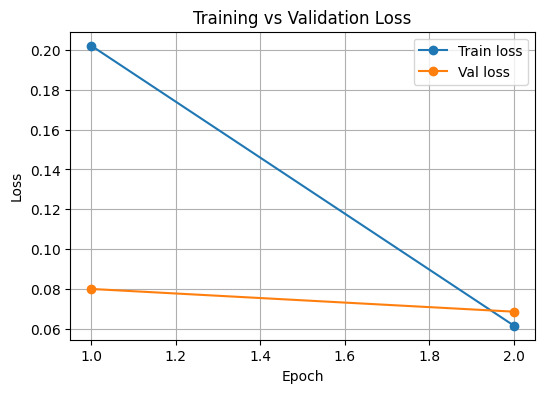

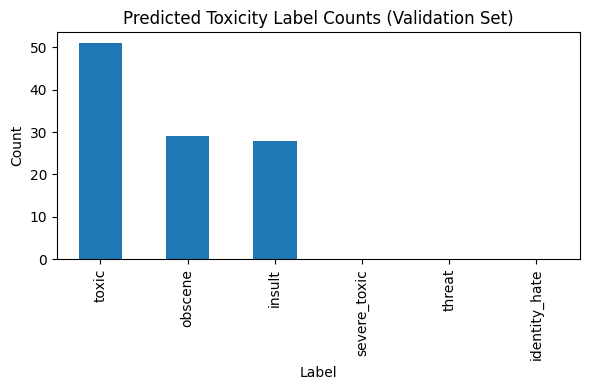

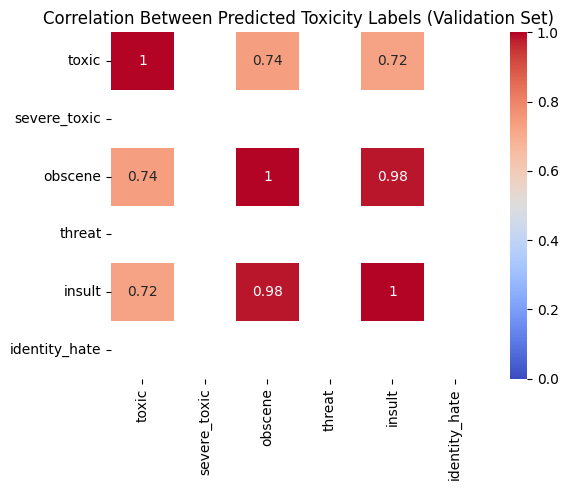


=== MODEL PERFORMANCE ON VALIDATION SET ===
Micro F1:  0.7064
Macro F1:  0.3725
Subset Accuracy: 0.9020

Per-label F1 scores:
toxic: 0.7500
severe_toxic: 0.0000
obscene: 0.8065
threat: 0.0000
insult: 0.6786
identity_hate: 0.0000


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 64
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 2e-5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

LABEL_COLS = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate",
]

train_df = pd.read_csv("data/train.csv")
train_df = train_df.sample(5000, random_state=42)

test_df = pd.read_csv("data/test.csv")

train_df["comment_text"] = train_df["comment_text"].fillna("")
test_df["comment_text"] = test_df["comment_text"].fillna("")

train_texts = train_df["comment_text"].tolist()
train_labels = train_df[LABEL_COLS].values.astype(float)

train_texts_tr, train_texts_val, labels_tr, labels_val = train_test_split(
    train_texts,
    train_labels,
    test_size=0.1,
    random_state=42,
)

class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
        )
        item = {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float),
        }
        return item


class ToxicCommentsTestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
        )
        item = {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
        }
        return item

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = ToxicCommentsDataset(
    train_texts_tr, labels_tr, tokenizer, MAX_LEN
)
val_dataset = ToxicCommentsDataset(
    train_texts_val, labels_val, tokenizer, MAX_LEN
)
test_dataset = ToxicCommentsTestDataset(
    test_df["comment_text"].tolist(), tokenizer, MAX_LEN
)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL_COLS),
    problem_type="multi_label_classification",
)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps,
)

train_losses_history = []
val_losses_history = []

def train_one_epoch(epoch):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train loss: {avg_loss:.4f}")
    return avg_loss


def eval_one_epoch(epoch):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
            )
            loss = outputs.loss
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Val loss: {avg_loss:.4f}")
    return avg_loss


for epoch in range(EPOCHS):
    train_loss = train_one_epoch(epoch)
    val_loss = eval_one_epoch(epoch)

    train_losses_history.append(train_loss)
    val_losses_history.append(val_loss)

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_losses_history, marker="o", label="Train loss")
plt.plot(epochs_range, val_losses_history, marker="o", label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
all_val_probs = []
all_val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].cpu().numpy()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()  # (batch_size, 6)

        all_val_probs.append(probs)
        all_val_labels.append(labels)

all_val_probs = np.concatenate(all_val_probs, axis=0)
all_val_labels = np.concatenate(all_val_labels, axis=0)

threshold = 0.5
val_preds_bin = (all_val_probs >= threshold).astype(int)

pred_df = pd.DataFrame(val_preds_bin, columns=LABEL_COLS)
true_df = pd.DataFrame(all_val_labels, columns=LABEL_COLS)

pred_counts = pred_df.sum().sort_values(ascending=False)

plt.figure(figsize=(6, 4))
pred_counts.plot(kind="bar")
plt.title("Predicted Toxicity Label Counts (Validation Set)")
plt.ylabel("Count")
plt.xlabel("Label")
plt.tight_layout()
plt.show()

pred_corr = pred_df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(pred_corr, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlation Between Predicted Toxicity Labels (Validation Set)")
plt.tight_layout()
plt.show()

micro_f1 = f1_score(true_df, pred_df, average='micro')
macro_f1 = f1_score(true_df, pred_df, average='macro')
per_label_f1 = f1_score(true_df, pred_df, average=None)
per_label_f1 = dict(zip(LABEL_COLS, per_label_f1))

subset_acc = accuracy_score(true_df, pred_df)

print("\n=== MODEL PERFORMANCE ON VALIDATION SET ===")
print(f"Micro F1:  {micro_f1:.4f}")
print(f"Macro F1:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")
print("\nPer-label F1 scores:")
for label, score in per_label_f1.items():
    print(f"{label}: {score:.4f}")

Using device: cpu


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2 - Train loss: 0.1313
Epoch 1/2 - Val loss: 0.0688
Epoch 2/2 - Train loss: 0.0481
Epoch 2/2 - Val loss: 0.0582


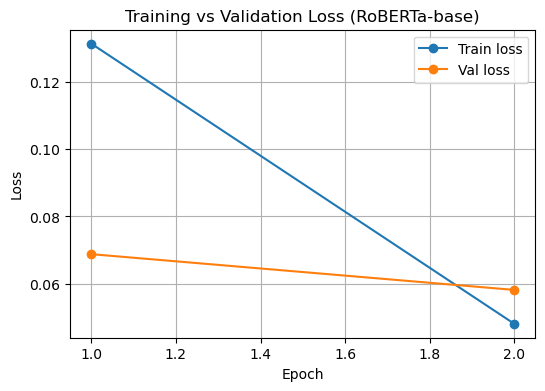

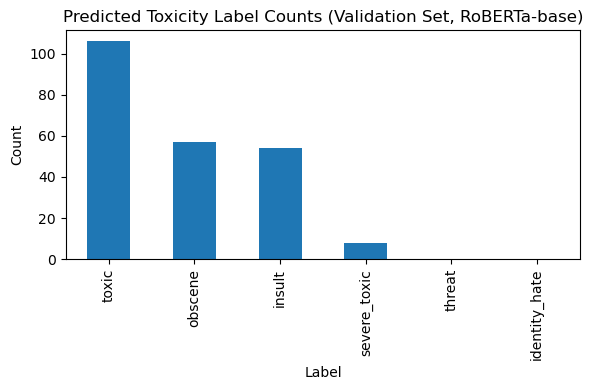

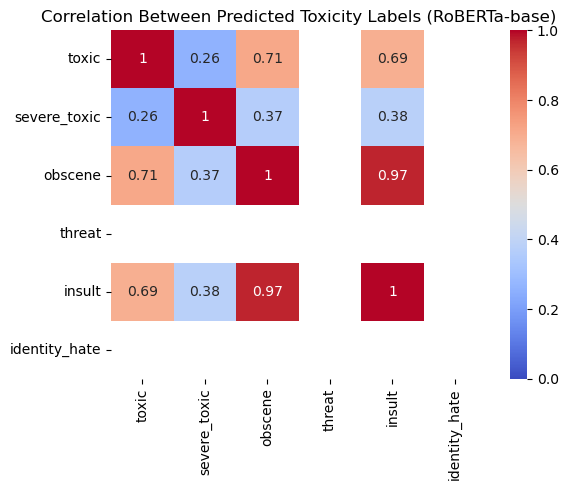


=== MODEL PERFORMANCE ON VALIDATION SET (RoBERTa-base) ===
Micro F1:  0.7393
Macro F1:  0.4745
Subset Accuracy: 0.9150

Per-label F1 scores:
toxic: 0.8000
severe_toxic: 0.5833
obscene: 0.7544
threat: 0.0000
insult: 0.7091
identity_hate: 0.0000


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score   # NEW
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_NAME = "roberta-base"

MAX_LEN = 64
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 2e-5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

LABEL_COLS = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate",
]

train_df = pd.read_csv("data/train.csv")
train_df = train_df.sample(10000, random_state=42)  # subsample for speed

test_df = pd.read_csv("data/test.csv")

train_df["comment_text"] = train_df["comment_text"].fillna("")
test_df["comment_text"] = test_df["comment_text"].fillna("")

train_texts = train_df["comment_text"].tolist()
train_labels = train_df[LABEL_COLS].values.astype(float)

train_texts_tr, train_texts_val, labels_tr, labels_val = train_test_split(
    train_texts,
    train_labels,
    test_size=0.1,
    random_state=42,
)

class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
        )
        item = {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float),
        }
        return item


class ToxicCommentsTestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
        )
        item = {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
        }
        return item

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = ToxicCommentsDataset(
    train_texts_tr, labels_tr, tokenizer, MAX_LEN
)
val_dataset = ToxicCommentsDataset(
    train_texts_val, labels_val, tokenizer, MAX_LEN
)
test_dataset = ToxicCommentsTestDataset(
    test_df["comment_text"].tolist(), tokenizer, MAX_LEN
)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL_COLS),
    problem_type="multi_label_classification",
)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps,
)

train_losses_history = []
val_losses_history = []

def train_one_epoch(epoch):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train loss: {avg_loss:.4f}")
    return avg_loss


def eval_one_epoch(epoch):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
            )
            loss = outputs.loss
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Val loss: {avg_loss:.4f}")
    return avg_loss

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(epoch)
    val_loss = eval_one_epoch(epoch)

    train_losses_history.append(train_loss)
    val_losses_history.append(val_loss)

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_losses_history, marker="o", label="Train loss")
plt.plot(epochs_range, val_losses_history, marker="o", label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (RoBERTa-base)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
all_val_probs = []
all_val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].cpu().numpy()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()  # (batch_size, 6)

        all_val_probs.append(probs)
        all_val_labels.append(labels)

all_val_probs = np.concatenate(all_val_probs, axis=0)
all_val_labels = np.concatenate(all_val_labels, axis=0)

threshold = 0.5
val_preds_bin = (all_val_probs >= threshold).astype(int)

pred_df = pd.DataFrame(val_preds_bin, columns=LABEL_COLS)
true_df = pd.DataFrame(all_val_labels, columns=LABEL_COLS)

pred_counts = pred_df.sum().sort_values(ascending=False)

plt.figure(figsize=(6, 4))
pred_counts.plot(kind="bar")
plt.title("Predicted Toxicity Label Counts (Validation Set, RoBERTa-base)")
plt.ylabel("Count")
plt.xlabel("Label")
plt.tight_layout()
plt.show()

pred_corr = pred_df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(pred_corr, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlation Between Predicted Toxicity Labels (RoBERTa-base)")
plt.tight_layout()
plt.show()

micro_f1 = f1_score(true_df, pred_df, average='micro')
macro_f1 = f1_score(true_df, pred_df, average='macro')
per_label_f1 = f1_score(true_df, pred_df, average=None)
per_label_f1 = dict(zip(LABEL_COLS, per_label_f1))

subset_acc = accuracy_score(true_df, pred_df)

print("\n=== MODEL PERFORMANCE ON VALIDATION SET (RoBERTa-base) ===")
print(f"Micro F1:  {micro_f1:.4f}")
print(f"Macro F1:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")
print("\nPer-label F1 scores:")
for label, score in per_label_f1.items():
    print(f"{label}: {score:.4f}")